In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! cp /content/drive/MyDrive/MNIST_SNN_FG_SUB/utils.py .
import utils
! cp  /content/drive/MyDrive/MNIST_SNN_FG_SUB/snn_utils.py .
import snn_utils
! cp  /content/drive/MyDrive/MNIST_SNN_FG_SUB/loss.py .
import loss
! cp /content/drive/MyDrive/MNIST_SNN_FG_SUB/power/network_model_p.py .
import network_model_p
! cp  /content/drive/MyDrive/MNIST_SNN_FG_SUB/power/non_linear_decolle_model_p.py .
import non_linear_decolle_model_p




In [ ]:
import torch
import pylab as plt
device = 'cpu' #cpu/ cuda (available one)

gen_test = snn_utils.get_mnist_loader(100, Nparts=1, train=False)

T = 100 #duration of sequence
data, target = next(loss.iter_mnist(gen_test, T=T))

net = non_linear_decolle_model_p.LenetDECOLLE(input_shape = data.shape[2:], Mhid = [150,120], num_conv_layers=0, num_mlp_layers=2, alpha=[.95],beta=[0] ,lc_ampl=.5, out_channels=10, power=True, area= True).to(device)

net
data_d = data.to(device)
target_d = target.to(device)
net.init_parameters(data_d.transpose(0,1))



In [5]:
PATH = '/content/drive/MyDrive/MNIST_SNN_FG_SUB/mnist_network_fg_nn_spike.pth'
net.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix

import numpy

error = []
accuracy=[]
y_pred = []
y_true = []


for data, label in loss.iter_mnist(gen_test, T=T):
        loss_hist = 0
        data_d = data.to(device)
        label_d = label.to(device)
        net.init(data_d.transpose(0,1), burnin=0)
        readout = 0
        with torch.no_grad():
          for n in range(T):
             st, rt, ut=net.forward(data_d[n])
             loss_tv = loss.decolle_loss(rt, st, label_d[n])
             
             loss_hist += loss_tv
             readout += rt[-1]
          output = (readout.argmax(axis=1)).data.cpu().numpy()
          y_pred.extend(output)
          labels =(label_d[-1].argmax(axis=1)).data.cpu().numpy()
          y_true.extend(labels)
          accuracy+=(readout.argmax(axis=1)==label_d[-1].argmax(axis=1)).float()
          error += (readout.argmax(axis=1)!=label_d[-1].argmax(axis=1)).float()
print('Testing Error', torch.mean(torch.Tensor(error)).data)
print('Testing accuracy', torch.mean(torch.Tensor(accuracy)).data)
accuracy=torch.mean(torch.Tensor(accuracy)).item()
# Build confusion matrix
classes = ('O', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')
cm = confusion_matrix(y_true, y_pred)

cm

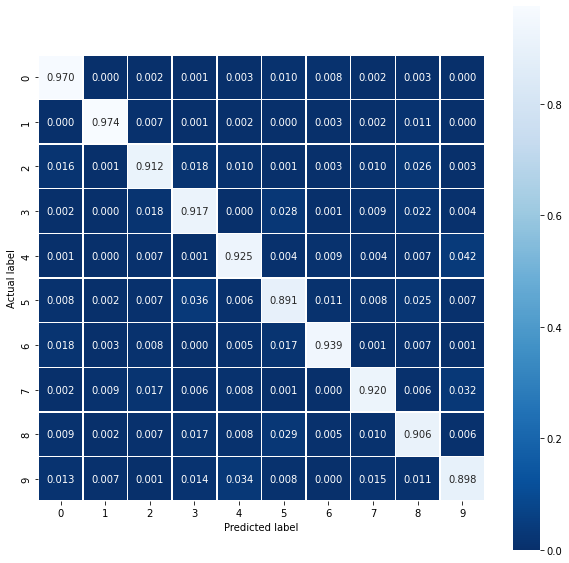

In [ ]:
# Used for Confusion Matrix
from sklearn import metrics
import seaborn as sns
import numpy as np
cm = metrics.confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]



plt.figure(figsize=(10,10))
sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
#all_sample_title = 'Accuracy = {} %'.format(np.accuracy)*100 
#plt.title(all_sample_title, size = 5);
plt.savefig('/content/drive/MyDrive/mnist_new_design_adap_EKV/confusion_matrix_10epoch_30.svg')

In [ ]:
power= (net.LIF_layers[0].base_layer.get_avg_power() + net.LIF_layers[1].base_layer.get_avg_power())
print(f' Power: {power*1000} mW')

In [ ]:
area= (net.LIF_layers[0].base_layer.get_area() + net.LIF_layers[1].base_layer.get_area())
print(f' Area: {area} mm^2')